In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import time
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load the data from the text file
df = pd.read_csv("monthly_milk_production.csv", parse_dates=True, index_col="Month")

In [3]:
df[:5]

,Production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


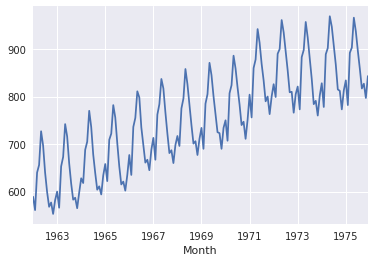

In [4]:
df.Production.plot();

In [5]:
# Setting the window size for the time series, we'll create samples of length seq_len for each window
seq_len = 24 
# Create a matrix of #observations / seq_len x seq_len 
result = []
for i in range(len(df) - seq_len):
    result.append(df.Production[i:i+seq_len].values)

In [6]:
# Normalize the data as neural networks are sensitive to scale, we convert the sequences to change ratios 
# relative to the first entry in the sequence
def normalize(data):
    return [[((s / float(seq[0])) - 1) for s in seq] for seq in data]

result = np.array(normalize(result))

In [7]:
# Split the data 70/30 train/test
row = int(round(0.7 * result.shape[0]))
train = result[:row, :]
test = result[row:, :]

# For each row take all observations but the last one (which is the one to predict)
X_train = train[:, :-1] 
y_train = train[:, -1] # the last observation 
X_test = test[:, :-1]
y_test = test[:, -1]

In [8]:
# Restructure the matrix so that for each sample we've got seq_len entries of number of predictors. This naive approach only 
# uses the previous values, external regressors are not included. Keras expects the input data to be of the dimensions
# number of samples x sequence length x number of predictors
X_train = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
# Using a single LSTM layer which has an input dimension of 1 as we only use the previous values (compare to ARIMA models).
# The output dimension is again 1, as we only predict the next value.
layers = [1, 50, 1]

model = Sequential()
model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=False))
model.add(Dropout(0.2))
# It's possible to stack multiple LSTM layers, just make sure that the previous layer returns sequences
#model.add(LSTM(layers[2], return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(output_dim=layers[2]))
model.add(Activation("linear"))

# Show the details of the model, including the number of parameters to optimize
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 50)            10400       lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 50)            0           lstm_1[0][0]                     
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             51          dropout_1[0][0]                  
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1)             0           dense_1[0][0]                    
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_____________________

In [10]:
start = time.time()
model.compile(loss="mse", optimizer="adam")
print "Compile time: ", time.time() - start

epochs = 1000
start = time.time()
model.fit(X_train, y_train, batch_size=16, nb_epoch=epochs, verbose=0, validation_split=0.05)
print "Training time: ", time.time() - start, " for ", epochs, " epochs"

Compile time:  0.0565609931946
Training time:  91.8024339676  for  1000  epochs


In [11]:
# single step prediction
predicted = model.predict(X_test)
predicted = np.reshape(predicted, (predicted.size,))

In [12]:
# multiple step prediction
curr_x = X_test[:1, :, :]
predicted_m = []
for i in range(len(test)):
    y = model.predict(curr_x)[0, 0]
    curr_x = np.roll(curr_x, -1)
    curr_x[0, seq_len - 2, 0] = y
    predicted_m.append(y)


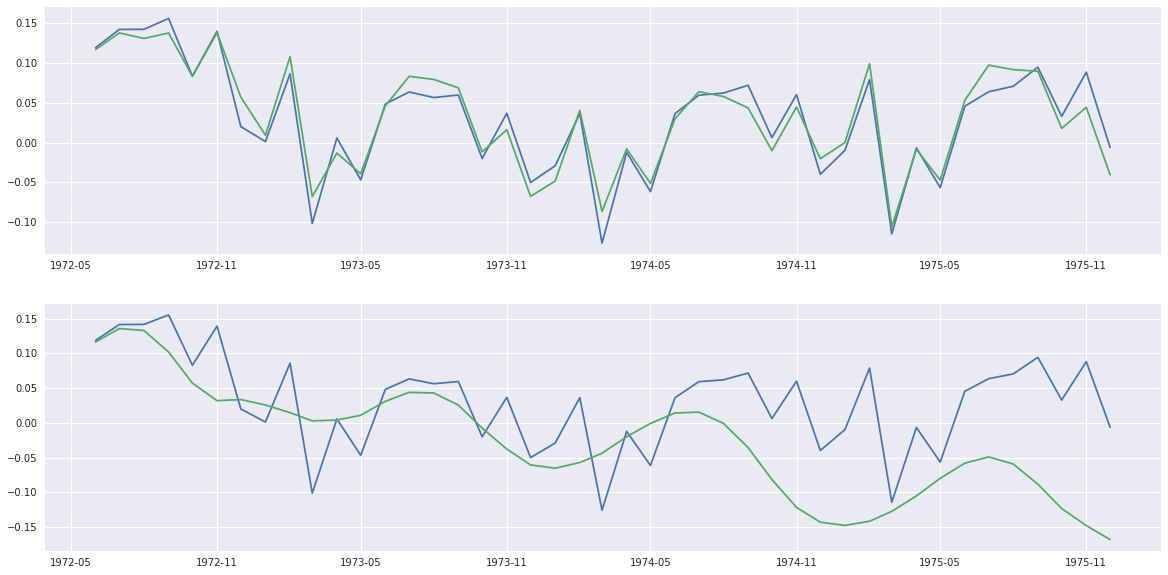

In [13]:
plt.figure(figsize=(20, 10))
nrows, ncols = 2, 1
x = df.index[row+seq_len:]
ax = plt.subplot2grid((nrows, ncols), (0, 0))
ax.plot(x, y_test, x, predicted);
ax = plt.subplot2grid((nrows, ncols), (1, 0))
ax.plot(x, y_test, x, predicted_m);
